In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('./cleaned_health_data.csv')


# Binary Encoding

In [3]:
binary_categorical_cols = ['gender','ever_married', 'Residence_type']

for col in binary_categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


    # To see the mapping (optional)
    print(f"Label Encoding for column '{col}': {dict(zip(le.classes_, le.transform(le.classes_)))}")

Label Encoding for column 'gender': {'Female': 0, 'Male': 1}
Label Encoding for column 'ever_married': {'No': 0, 'Yes': 1}
Label Encoding for column 'Residence_type': {'Rural': 0, 'Urban': 1}


# Multi categorical encoding

drop first = true : drop one column to fix multicollinearity 

In [4]:
multi_categorical_cols = ['work_type', 'smoking_status']
df = pd.get_dummies(df, columns=multi_categorical_cols, drop_first=True)

# Correlation mtx

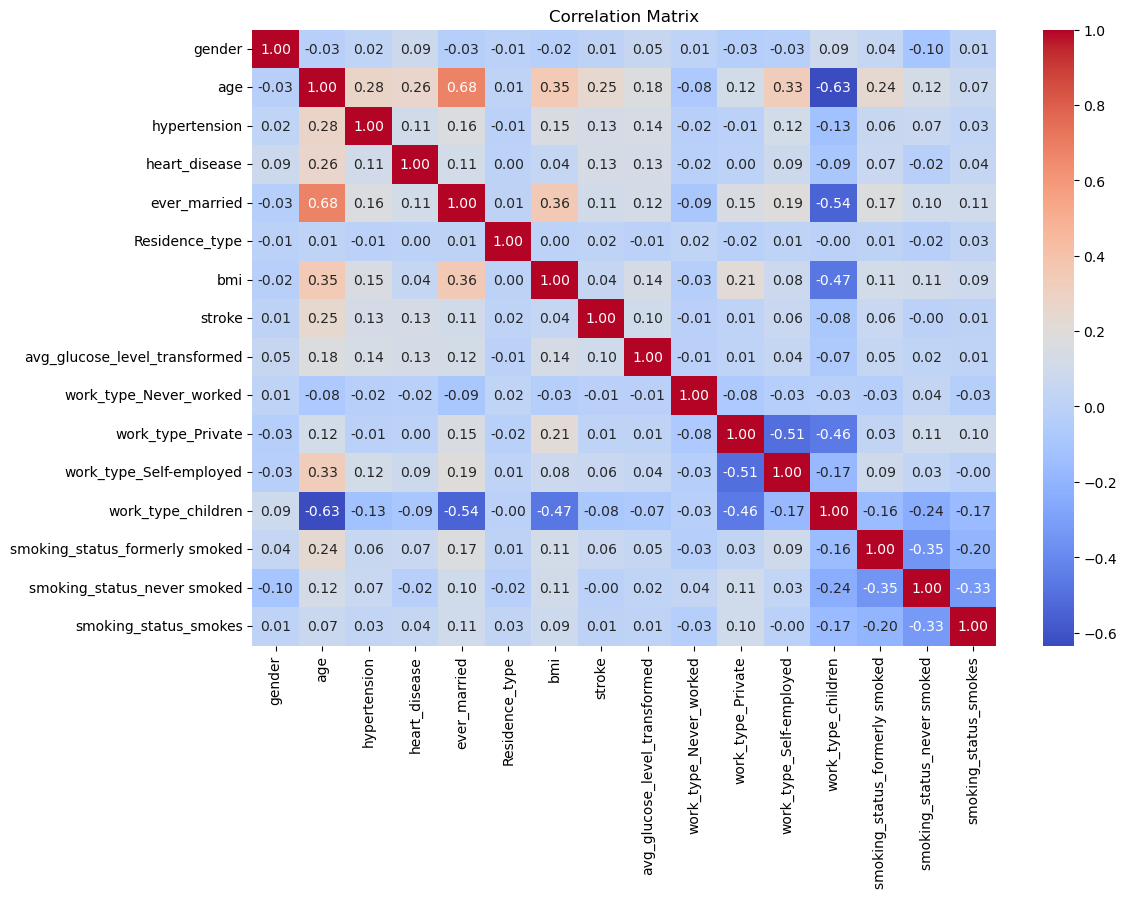

In [5]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Ploting the heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Scaling after encoding

In [6]:
# Identify the numerical columns
numerical_cols = ['age', 'bmi', 'avg_glucose_level_transformed']

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the numerical features in the training set
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Prepare for split and train

In [7]:
#Defining features and Target
x = df.drop(columns=['stroke'])  # Features
y = df['stroke']  # Target variable

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# logistic reg without sampling

In [9]:
# Train Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict and Evaluate
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.9510763209393346
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



c:\Users\sanda\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sanda\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sanda\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# random forest without sampling

In [10]:
# Train Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and Evaluate
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9500978473581213
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



# xgboost without sampling

In [11]:
# Train XGBoost Model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Predict and Evaluate
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9403131115459883
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.18      0.06      0.09        50

    accuracy                           0.94      1022
   macro avg       0.56      0.52      0.53      1022
weighted avg       0.92      0.94      0.93      1022



c:\Users\sanda\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:50:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Show what the imbalance is in our dataset

In [12]:
# Count the number of instances in each class
class_counts = df['stroke'].value_counts()
print(class_counts)

# Percentage of each class
print("Class Distribution (%):")
print(df['stroke'].value_counts(normalize=True) * 100)

stroke
0    4860
1     249
Name: count, dtype: int64
Class Distribution (%):
stroke
0    95.126248
1     4.873752
Name: proportion, dtype: float64


Eventhough no sampling accuracy for all three models gives best results, the above proportioning explains our dataset is highly imbalanced. Therefore, perform sampling.

# Oversample

In [13]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Define SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to balance the dataset
X_resampled, y_resampled = smote.fit_resample(x, y)

# Check new class distribution
print(f"Original class distribution: {Counter(y)}")
print(f"Resampled class distribution: {Counter(y_resampled)}")


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)



Original class distribution: Counter({0: 4860, 1: 249})
Resampled class distribution: Counter({1: 4860, 0: 4860})


# Oversample logistic reg

In [14]:

# Train Logistic Regression Model
log_reg_oversampled = LogisticRegression()
log_reg_oversampled.fit(X_train, y_train)

# Predict and Evaluate
y_pred_log_OS = log_reg_oversampled.predict(X_test)
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_OS))
print(classification_report(y_test, y_pred_log_OS))


Logistic Regression Accuracy: 0.7988683127572016
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       976
           1       0.78      0.84      0.81       968

    accuracy                           0.80      1944
   macro avg       0.80      0.80      0.80      1944
weighted avg       0.80      0.80      0.80      1944



# Oversample random forest

In [15]:
# Train Random Forest Model
rf_Oversampled = RandomForestClassifier(n_estimators=100, random_state=42)
rf_Oversampled.fit(X_train, y_train)

# Predict and Evaluate
y_pred_rf_oversampled = rf_Oversampled.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf_oversampled))
print(classification_report(y_test, y_pred_rf_oversampled))

Random Forest Accuracy: 0.9511316872427984
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       976
           1       0.93      0.98      0.95       968

    accuracy                           0.95      1944
   macro avg       0.95      0.95      0.95      1944
weighted avg       0.95      0.95      0.95      1944



# Oversample xgboost

In [16]:
# Train XGBoost Model
xgb_oversampled = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_oversampled.fit(X_train, y_train)

# Predict and Evaluate
y_pred_xgb_oversampled = xgb_oversampled.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb_oversampled))
print(classification_report(y_test, y_pred_xgb_oversampled))

XGBoost Accuracy: 0.9356995884773662
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       976
           1       0.92      0.95      0.94       968

    accuracy                           0.94      1944
   macro avg       0.94      0.94      0.94      1944
weighted avg       0.94      0.94      0.94      1944



c:\Users\sanda\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Undersample

In [17]:
from imblearn.under_sampling import RandomUnderSampler

# Define undersampling
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply undersampling
X_resampled, y_resampled = undersample.fit_resample(x, y)

# Check new class distribution
print(f"Original class distribution: {Counter(y)}")
print(f"Resampled class distribution: {Counter(y_resampled)}")

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Original class distribution: Counter({0: 4860, 1: 249})
Resampled class distribution: Counter({0: 249, 1: 249})


# Undersample logistic reg

In [18]:
# Train Logistic Regression Model
log_reg_undersampled = LogisticRegression()
log_reg_undersampled.fit(X_train, y_train)

# Predict and Evaluate
y_pred_log_undersampled = log_reg_undersampled.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_undersampled))
print(classification_report(y_test, y_pred_log_undersampled))

Logistic Regression Accuracy: 0.76
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        51
           1       0.73      0.82      0.77        49

    accuracy                           0.76       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.76      0.76      0.76       100



# Undersample randowm forest


In [19]:
# Train Random Forest Model
rf_undersampled = RandomForestClassifier(n_estimators=100, random_state=42)
rf_undersampled.fit(X_train, y_train)

# Predict and Evaluate
y_pred_rf_undersampled = rf_undersampled.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf_undersampled))
print(classification_report(y_test, y_pred_rf_undersampled))

Random Forest Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.83      0.78      0.81        51
           1       0.79      0.84      0.81        49

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100



# Undersample xgboost

In [20]:
# Train XGBoost Model
xgb_undersampled = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_undersampled.fit(X_train, y_train)

# Predict and Evaluate
y_pred_xgb_undersampled = xgb_undersampled.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb_undersampled))
print(classification_report(y_test, y_pred_xgb_undersampled))

XGBoost Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        51
           1       0.80      0.84      0.82        49

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100



c:\Users\sanda\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
